# Лабораторная работа №6. Простой policy gradient алгоритм (REINFORCE)

## Использование PyTorch
Разработаем сеть на PyTorch для изучения
CartPole-v0 с помощью градиента политик (REINFORCE).

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


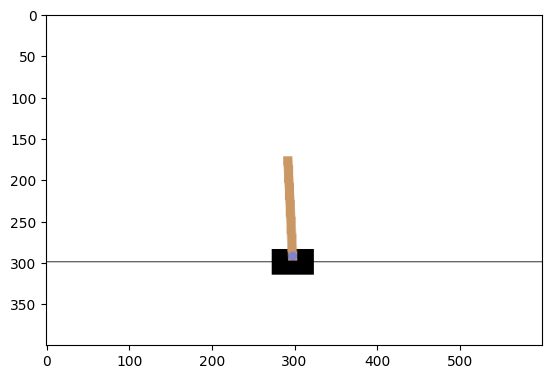

In [28]:
import sys, os
# Этот код создает виртуальный дисплей для рисования игровых изображений.
# Это не будет иметь никакого эффекта, если на вашей машине есть монитор.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    os.environ['DISPLAY'] = ':1'

import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CartPole-v0", render_mode="rgb_array") # gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
plt.imshow(env.render())

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

Для алгоритма REINFORCE нам понадобится модель, которая предсказывает
вероятности действий при заданных состояниях. Для стабильной работы не
включайте слой softmax в вашу сетевую архитектуру. Мы будем использовать
softmax или log-softmax, где это уместно.

In [87]:
class PolicyGradientAgent(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(PolicyGradientAgent, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

In [80]:
def predict_probs(states):
    """
    Прогнозировать вероятности действий при заданных состояниях.
    :paramstates: numpy массив форм [batch, state_shape]
    :returns: numpy массив формы [пакет, n_actions]
    """
    agent.eval()
    
    with torch.no_grad():
        states_tensor = torch.tensor(states, dtype=torch.float32)
        
        logits = agent(states_tensor)
        
        probabilities = F.softmax(logits, dim=1)
    
    return probabilities.data.numpy()

## Игра с моделью

In [83]:
def generate_session(env, t_max=1000):
    """
    Сыграйте полную сессию с агентом REINFORCE.
    Возвращает последовательности состояний, действий и наград.
    """
    # массивы для записи сессии
    states, actions, rewards = [], [], []
    s = env.reset()[0]

    for t in range(t_max):
        # массив вероятностей действий pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]
        # Пример действия с заданной вероятностью
        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, terminated, truncated, _ = env.step(a)
        # записать историю сессий, для последующего обучения
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = new_s
        if terminated or truncated:
            break

    return states, actions, rewards

# Проверка
states, actions, rewards = generate_session(env)

## Расчет кумулятивных вознаграждений.

In [85]:
def get_cumulative_rewards(rewards, # вознаграждение на каждом шаге
                           gamma=0.99 # дисконт для вознаграждение
                           ):
    """
    Возьмите список немедленных вознаграждений r(s,a) за всю сессию
    и вычислить кумулятивную доходность (также известную как G(s,a) в Sutton '16).
    G_t = r_t + гамма*r_{t+1} + гамма^2*r_{t+2} + ...
    Простой способ вычислить кумулятивное вознаграждение состоит в том, чтобы выполнить
    итерацию, начиная с последнего к первому временному шагу и рекуррентно вычислить G_t = r_t +
    gamma*G_{t+1}
    Вы должны вернуть массив/список кумулятивных вознаграждений с таким же количеством
    элементов, как и в начальных вознаграждениях.
    """
    # rewards = torch.tensor(rewards, dtype=torch.float32)
    cumulative_rewards = torch.zeros_like(rewards, dtype=torch.float32)
    G_t = 0
    for t in reversed(range(len(rewards))):
        G_t = rewards[t] + gamma * G_t
        cumulative_rewards[t] = G_t
    return cumulative_rewards

In [72]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


## Функция потерь и обновления.

In [75]:
def train_on_session(states, actions, rewards):
    """в полном объеме обучает агента градиенту политики"""
    
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long)
    rewards = torch.tensor(rewards, dtype=torch.float32)

    logits = agent(states)
    policy = F.softmax(logits, dim=1)
    log_policy = F.log_softmax(logits, dim=1)

    log_policy_for_actions = log_policy[torch.arange(len(actions)), actions]

    cumulative_rewards = get_cumulative_rewards(rewards)

    J = torch.mean(log_policy_for_actions * cumulative_rewards)

    entropy = torch.mean(torch.sum(policy * log_policy, dim=1))

    loss = -(J + 0.1 * entropy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return sum(rewards)

## Актуальное обучение

In [88]:
agent = PolicyGradientAgent(state_dim[0], n_actions)
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-3)

for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # создание новой сессии
    print("mean reward: %.3f" % (np.mean(rewards)))
    if np.mean(rewards) > 300:
        print("You Win!")  # но обучение может быть продолжено
        break

mean reward: 21.950
mean reward: 36.470
mean reward: 44.830
mean reward: 59.130
mean reward: 83.340
mean reward: 167.550
mean reward: 136.500
mean reward: 185.210
mean reward: 302.100
You Win!
